In [1]:
import pandas as pd
import json
import os
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn import metrics

fontsize = 18

In [2]:
def load_df(csv_path='../data/ga-customer-revenue-prediction/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = pd.io.json.json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [3]:
train_df = load_df()
test_df = load_df('../data/ga-customer-revenue-prediction/test.csv')

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)


In [9]:
train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].astype(float)
train_df["totals.transactionRevenue"].fillna(0, inplace=True)

train_df['sessionId_0'] = train_df.sort_values('date')['sessionId'].apply(lambda row: row.split('_')[0]).astype(float)
train_df['sessionId_1'] = train_df.sort_values('date')['sessionId'].apply(lambda row: row.split('_')[1]).astype(float)

test_df['sessionId_0'] = test_df.sort_values('date')['sessionId'].apply(lambda row: row.split('_')[0]).astype(float)
test_df['sessionId_1'] = test_df.sort_values('date')['sessionId'].apply(lambda row: row.split('_')[1]).astype(float)

train_df.drop('sessionId', axis=1, inplace=True)
test_df.drop('sessionId', axis=1, inplace=True)

const_cols_train = [c for c in train_df.columns if train_df[c].nunique(dropna=False) == 1]
const_cols_test = [c for c in test_df.columns if test_df[c].nunique(dropna=False) == 1]

print('Amount non-informative columns in train and in test simultaneously: ', np.intersect1d(const_cols_train, const_cols_test).shape[0])
print('Amount non-informative columns in train: ', len(const_cols_train))
print('Amount non-informative columns in test: ', len(const_cols_test))

train_df = train_df.drop(const_cols_test, axis=1)
test_df = test_df.drop(const_cols_test, axis=1)    

del const_cols_test
del const_cols_train

train_df = train_df.drop('trafficSource.campaignCode', axis=1)

train_df['fullVisitorId'] = '#' + train_df['fullVisitorId']
test_df['fullVisitorId'] = '#' + test_df['fullVisitorId']

train_df.to_csv('../data/ga-customer-revenue-prediction/prepared_train.csv')
test_df.to_csv('../data/ga-customer-revenue-prediction/prepared_test.csv')

Amount non-informative columns in train and in test simultaneously:  19
Amount non-informative columns in train:  19
Amount non-informative columns in test:  19


In [2]:
train_df = pd.read_csv('../data/ga-customer-revenue-prediction/prepared_train.csv')
test_df = pd.read_csv('../data/ga-customer-revenue-prediction/prepared_test.csv')
test_df['date'] = pd.to_datetime(test_df['date'], format='%Y-%m-%d')
train_df['date'] = pd.to_datetime(train_df['date'], format='%Y-%m-%d')
train_df['fullVisitorId'] = train_df['fullVisitorId'].apply(lambda row: row[1:])
test_df['fullVisitorId'] = test_df['fullVisitorId'].apply(lambda row: row[1:])

**NOTICE: A lot of people take a transaction the only**

**NOTICE: trafficSource.campaignCode is not informative feature. Drop it. Test set not consist this feature**

In [19]:
print("Number of common visitors in train and test set : ", len(set(train_df.fullVisitorId.unique()).intersection(set(test_df.fullVisitorId.unique())) ))

Number of common visitors in train and test set :  7679


**NOTICE: It means that people intersection in test in train. This is a very good**

In [58]:
gr_train_df = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()
nzi = train_df[train_df["totals.transactionRevenue"] > 0]['totals.transactionRevenue'].count()
nzr = (gr_train_df["totals.transactionRevenue"]>0).sum()
print("Number of instances in train set with non-zero revenue : ", nzi, " and ratio is : ", nzi / train_df.shape[0])
print("Number of unique customers with non-zero revenue : ", nzr, "and the ratio is : ", nzr / gr_train_df.shape[0])
del nzr
del nzi
del gr_train_df

Number of instances in train set with non-zero revenue :  11515  and ratio is :  0.0127427231470487
Number of unique customers with non-zero revenue :  9996 and the ratio is :  0.013996726255903731


**NOTICE: We can predict one features by other features for validation and as additional features**

**NOTICE: We should be classify zero and non-zero transaction. After that we can predict transaction value for non-zero calss**

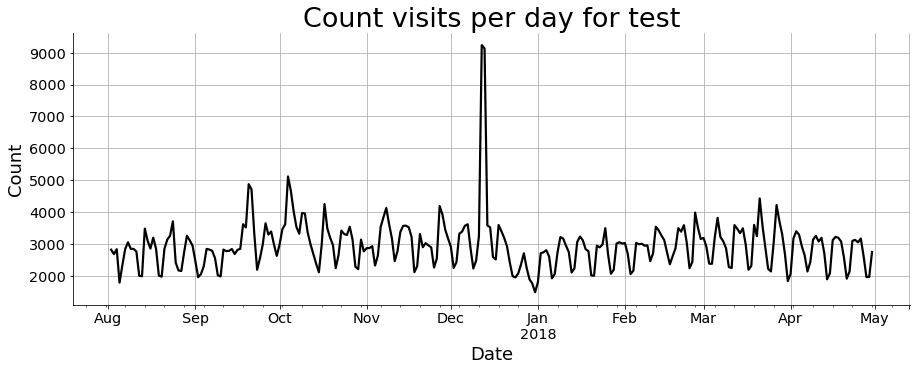

In [12]:
ax = test_df.groupby('date')['sessionId'].count().plot(figsize=(15, 5), color='k', linewidth=2.2)
plt.title('Count visits per day for test', fontsize=fontsize * 1.5)
plt.xlabel('Date', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.xticks(fontsize=fontsize * 0.8)
plt.yticks(fontsize=fontsize * 0.8)
plt.grid(True)
sns.despine(top=True, right=True, left=False, bottom=False)

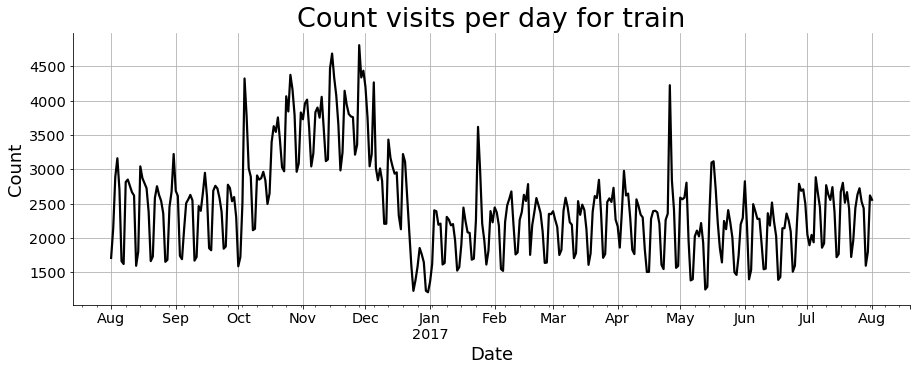

In [13]:
ax = train_df.groupby('date')['totals.transactionRevenue'].count().plot(figsize=(15, 5), color='k', linewidth=2.2)
plt.title('Count visits per day for train', fontsize=fontsize * 1.5)
plt.xlabel('Date', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.xticks(fontsize=fontsize * 0.8)
plt.yticks(fontsize=fontsize * 0.8)
plt.grid(True)
sns.despine(top=True, right=True, left=False, bottom=False)

**NOTICE: We can should be difference real value transaction and trend value transaction as distributions for train and test are differences**

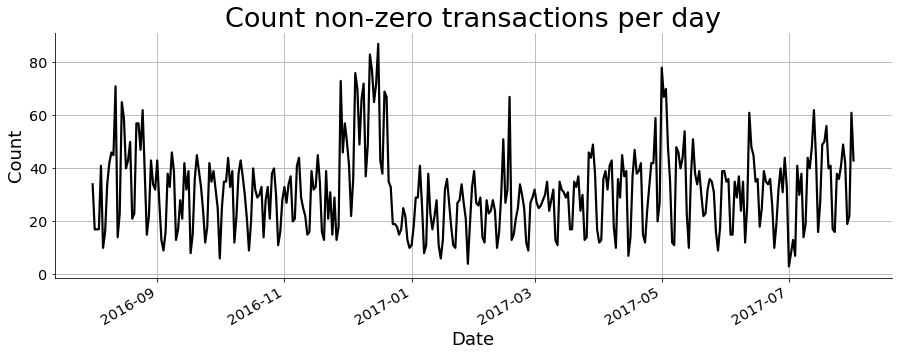

In [14]:
ax = train_df[train_df['totals.transactionRevenue'] > 0].groupby('date')['totals.transactionRevenue'].count().plot(figsize=(15, 5), color='k', linewidth=2.2)
plt.title('Count non-zero transactions per day', fontsize=fontsize * 1.5)
plt.xlabel('Date', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.xticks(fontsize=fontsize * 0.8)
plt.yticks(fontsize=fontsize * 0.8)
plt.grid(True)
sns.despine(top=True, right=True, left=False, bottom=False)

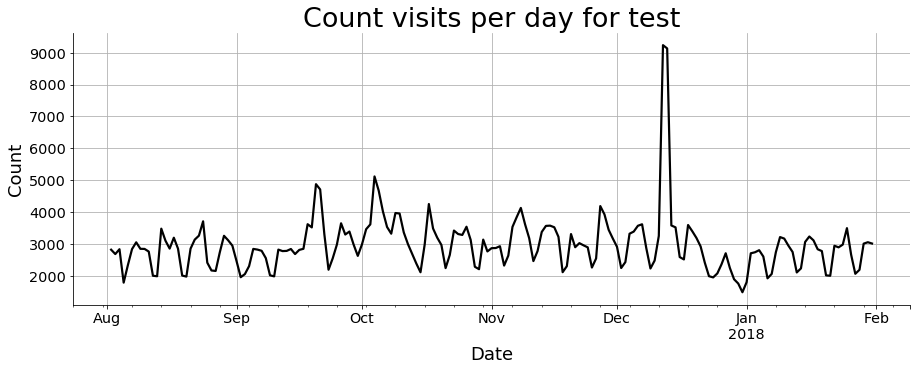

In [15]:
ax = test_df[test_df['date'] < pd.datetime(year=2018, month=2, day=1)].groupby('date')['sessionId'].count().plot(figsize=(15, 5), color='k', linewidth=2.2)
plt.title('Count visits per day for test', fontsize=fontsize * 1.5)
plt.xlabel('Date', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.xticks(fontsize=fontsize * 0.8)
plt.yticks(fontsize=fontsize * 0.8)
plt.grid(True)
sns.despine(top=True, right=True, left=False, bottom=False)

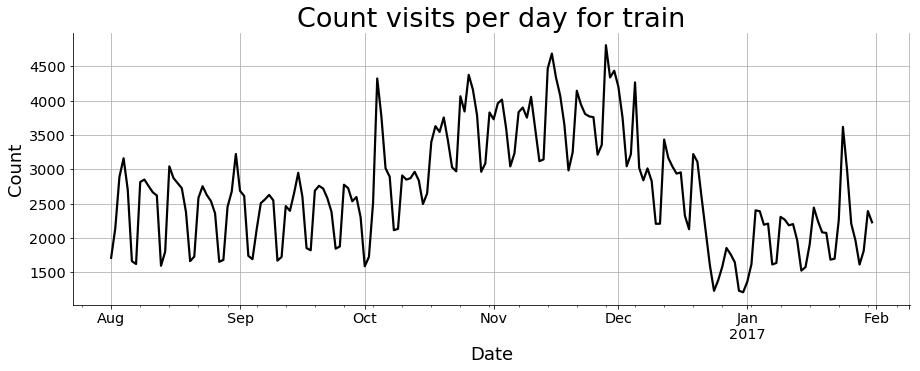

In [16]:
ax = train_df[train_df['date'] < pd.datetime(year=2017, month=2, day=1)].groupby('date')['sessionId'].count().plot(figsize=(15, 5), color='k', linewidth=2.2)
plt.title('Count visits per day for train', fontsize=fontsize * 1.5)
plt.xlabel('Date', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.xticks(fontsize=fontsize * 0.8)
plt.yticks(fontsize=fontsize * 0.8)
plt.grid(True)
sns.despine(top=True, right=True, left=False, bottom=False)

**NOTICE: Peoples visit a web-store the most often in the second day of week or the first day. Some weeks have 2-modal distribution.**

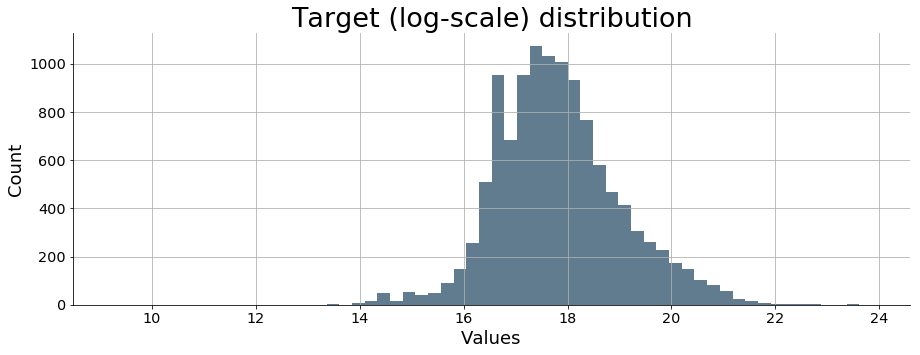

In [17]:
np.log(train_df[train_df['totals.transactionRevenue'] > 0]['totals.transactionRevenue']).plot.hist(figsize=(15,5), bins=60, color=sns.xkcd_rgb["blue grey"])
plt.title('Target (log-scale) distribution', fontsize=fontsize * 1.5)
plt.xlabel('Values', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.xticks(fontsize=fontsize * 0.8)
plt.yticks(fontsize=fontsize * 0.8)
plt.grid(True)
sns.despine(top=True, right=True, left=False, bottom=False)

**NOTICE: Left side of distribution is more mowed than right side.**

**NOTICE: If it takes different bins you will get some artifacts in the form of pits**

**NOTICE: sessionId has not trivial distribution**

# Baseline model (without Research)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import seaborn as sns
from sklearn.metrics import mean_squared_error, roc_auc_score, log_loss
import gc
import time
from pandas.core.common import SettingWithCopyWarning
import warnings
import lightgbm as lgb
from sklearn.model_selection import KFold, GroupKFold

warnings.simplefilter('error', SettingWithCopyWarning)
gc.enable()
%matplotlib inline

In [4]:
train_df_ = train_df.copy(deep=True)
test_df_ = test_df.copy(deep=True)

y_clf = (train_df_['totals.transactionRevenue'].fillna(0) > 0).astype(np.uint8)
y_reg = train_df_['totals.transactionRevenue'].fillna(0)
del train_df_['totals.transactionRevenue']
y_clf.mean(), y_reg.mean()

(0.0127427231470487, 1704272.8126836296)

In [5]:
for df in [train_df_, test_df_]:
    df['vis_date'] = pd.to_datetime(df['visitStartTime'])
    df['sess_date_dow'] = df['vis_date'].dt.dayofweek
    df['sess_date_hours'] = df['vis_date'].dt.hour
    df['sess_date_dom'] = df['vis_date'].dt.day

In [6]:
excluded_features = [
    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 
    'visitId', 'visitStartTime', 'non_zero_proba', 'vis_date'
]

categorical_features = [
    _f for _f in train_df_.columns
    if (_f not in excluded_features) & (train_df_[_f].dtype == 'object')
]

if 'totals.transactionRevenue' in train_df_.columns:
    del train_df_['totals.transactionRevenue']

if 'totals.transactionRevenue' in test_df_.columns:
    del test_df_['totals.transactionRevenue']

In [7]:
for f in categorical_features:
    train_df_[f], indexer = pd.factorize(train_df_[f])
    test_df_[f] = indexer.get_indexer(test_df_[f])

In [8]:
folds = GroupKFold(n_splits=5)

train_features = [_f for _f in train_df_.columns if _f not in excluded_features]
print(train_features)
oof_clf_preds = np.zeros(train_df_.shape[0])
sub_clf_preds = np.zeros(test_df_.shape[0])
for fold_, (trn_, val_) in enumerate(folds.split(y_clf, y_clf, groups=train_df_['fullVisitorId'])):
    trn_x, trn_y = train_df_[train_features].iloc[trn_], y_clf.iloc[trn_]
    val_x, val_y = train_df_[train_features].iloc[val_], y_clf.iloc[val_]
    
    clf = lgb.LGBMClassifier(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    clf.fit(
        trn_x, trn_y,
        eval_set=[(val_x, val_y)],
        early_stopping_rounds=50,
        verbose=50
    )
    
    oof_clf_preds[val_] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
    print(roc_auc_score(val_y, oof_clf_preds[val_]))
    sub_clf_preds += clf.predict_proba(test_df_[train_features], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    
roc_auc_score(y_clf, oof_clf_preds)

['Unnamed: 0', 'channelGrouping', 'visitNumber', 'device.browser', 'device.deviceCategory', 'device.isMobile', 'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign', 'trafficSource.isTrueDirect', 'trafficSource.keyword', 'trafficSource.medium', 'trafficSource.referralPath', 'trafficSource.source', 'sessionId_0', 'sessionId_1', 'sess_date_dow', 'sess_date_hours', 'sess_date_dom']
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.0302387
[100]	valid_0's binary_logloss: 0.0274548
[150]

0.9879738522857248

In [9]:
train_df_['non_zero_proba'] = oof_clf_preds
test_df_['non_zero_proba'] = sub_clf_preds

In [10]:
train_features = [_f for _f in train_df_.columns if _f not in excluded_features] + ['non_zero_proba']
print(train_features)

oof_reg_preds = np.zeros(train_df_.shape[0])
sub_reg_preds = np.zeros(test_df_.shape[0])
importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds.split(y_reg, y_reg, groups=train_df_['fullVisitorId'])):
    trn_x, trn_y = train_df_[train_features].iloc[trn_], y_reg.iloc[trn_].fillna(0)
    val_x, val_y = train_df_[train_features].iloc[val_], y_reg.iloc[val_].fillna(0)
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        verbose=50
    )
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_reg_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_reg_preds[oof_reg_preds < 0] = 0
    _preds = reg.predict(test_df_[train_features], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_reg_preds += np.expm1(_preds) / folds.n_splits
    
mean_squared_error(np.log1p(y_reg.fillna(0)), oof_reg_preds) ** .5

['Unnamed: 0', 'channelGrouping', 'visitNumber', 'device.browser', 'device.deviceCategory', 'device.isMobile', 'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign', 'trafficSource.isTrueDirect', 'trafficSource.keyword', 'trafficSource.medium', 'trafficSource.referralPath', 'trafficSource.source', 'sessionId_0', 'sessionId_1', 'sess_date_dow', 'sess_date_hours', 'sess_date_dom', 'non_zero_proba']
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's l2: 2.66657
[100]	valid_0's l2: 2.58677
[150]	valid_0's

1.6178961036145354

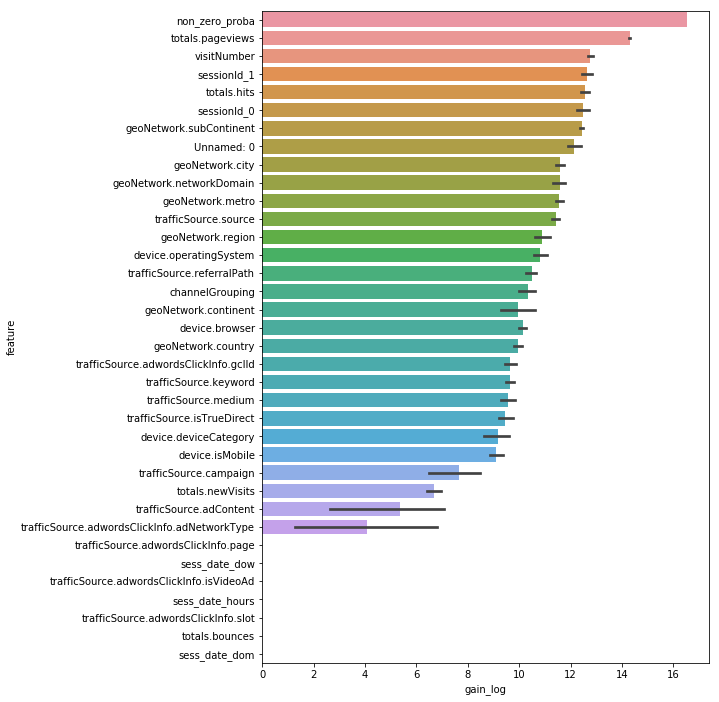

In [11]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

importances['gain_log'] = np.log1p(importances['gain'])
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 12))
sns.barplot(x='gain_log', y='feature', data=importances.sort_values('mean_gain', ascending=False))

In [22]:
test_df_['fullVisitorId'] = test_df_['fullVisitorId'].astype(str)
test_df_['PredictedLogRevenue'] = sub_reg_preds
test_df_[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum()['PredictedLogRevenue'].apply(np.log1p).reset_index()\
.to_csv('../data/ga-customer-revenue-prediction/10.10.18_1.csv', index=False)

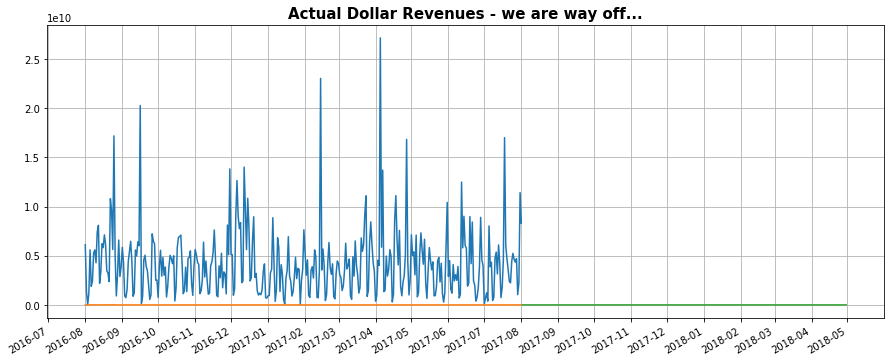

In [13]:
# Go to actual revenues
train_df_['PredictedRevenue'] = np.expm1(oof_reg_preds)
test_df_['PredictedRevenue'] = sub_reg_preds
train_df_['totals.transactionRevenue'] = y_reg

# Sum by date on train and test
trn_group = train_df_[['date', 'PredictedRevenue', 'totals.transactionRevenue']].groupby('date').sum().reset_index()
sub_group = test_df_[['date', 'PredictedRevenue']].groupby('date').sum().reset_index()

# Now plot all this
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y-%m')

fig, ax = plt.subplots(figsize=(15, 6))
ax.set_title('Actual Dollar Revenues - we are way off...', fontsize=15, fontweight='bold')
ax.plot(pd.to_datetime(trn_group['date']).values, trn_group['totals.transactionRevenue'].values)
ax.plot(pd.to_datetime(trn_group['date']).values, trn_group['PredictedRevenue'].values)
ax.plot(pd.to_datetime(sub_group['date']).values, sub_group['PredictedRevenue'].values)

# # format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
# # ax.format_ydata = price
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()